# Evaluation suite

***

In [1]:
import numpy as np
import pandas as pd
import sqlite3 as sql
import math
from matplotlib import pyplot as plt, dates, colors, patches
from datetime import datetime, timedelta
from dateutil.parser import parse
from tqdm import tqdm

%matplotlib inline

In [2]:
plt.rcParams['font.size'] = 14

In [3]:
def rotate_vel(u_in, v_in, theta=29):
    """Rotate velocities from map coordinates to grid coordinates
    """
    
    theta_rad = math.radians(theta)
    u_out = u_in * np.cos(theta_rad) + v_in * np.sin(theta_rad)
    v_out = -u_in * np.sin(theta_rad) + v_in * np.cos(theta_rad)
    
    return u_out, v_out

In [4]:
dateranges = ['20160401_20160930', '20161001_20170331', '20170401_20170930']
runIDs = ['frachs08', 'base', 'frachs13']
velocities = {runID: {'obs': {'u': [], 'v': []}, 'NEMO': {'u': [], 'v': []}} for runID in runIDs}

for runID in runIDs:

    for daterange in dateranges:

        # Open database
        con = sql.connect(f'/scratch/bmoorema/Drifters/SSCdrifters_{runID}_{daterange}.sqlite')

        # Print table names
        cursor = con.cursor()
        cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
        for drifter in cursor.fetchall():

            # Read a table to Pandas dataframe
            df = pd.read_sql_query(f'SELECT * from {drifter[0]}', con, parse_dates='time')

            # Compute drifter velocities from positions
            times = df['time'].values.astype('datetime64[s]').astype(datetime)
            lons, lats = [df[var].values for var in ('longitude', 'latitude')]
            dt = np.array([t.total_seconds() for t in np.diff(times)])
            uv = []
            for coord, theta in zip([lons, lats], [0, np.deg2rad(lats[:-1])]):
                uv.append(np.diff(coord) / dt * 111000 * np.cos(theta))

            # Add to lists
            for var, val in zip(['u', 'v'], rotate_vel(*uv)):
                velocities[runID]['obs'][var].append(val)
                velocities[runID]['NEMO'][var].append(df[var].values[:-1])

        con.close()
    
    for key in ['obs', 'NEMO']:
        for var in ['u', 'v']:
            velocities[runID][key][var] = np.hstack(velocities[runID][key][var])

/tmp/ipykernel_24448/1320771132.py:26: RuntimeWarning: divide by zero encountered in true_divide
  uv.append(np.diff(coord) / dt * 111000 * np.cos(theta))
/tmp/ipykernel_24448/1320771132.py:26: RuntimeWarning: invalid value encountered in true_divide
  uv.append(np.diff(coord) / dt * 111000 * np.cos(theta))
/tmp/ipykernel_24448/3316846.py:6: RuntimeWarning: invalid value encountered in add
  u_out = u_in * np.cos(theta_rad) + v_in * np.sin(theta_rad)
/tmp/ipykernel_24448/3316846.py:7: RuntimeWarning: invalid value encountered in add
  v_out = -u_in * np.sin(theta_rad) + v_in * np.cos(theta_rad)


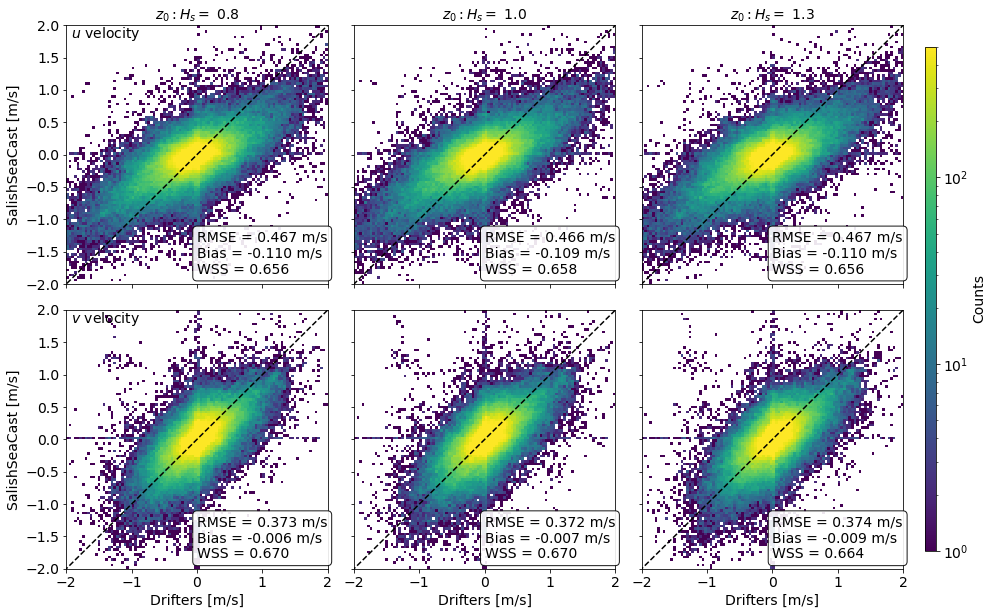

In [41]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10), gridspec_kw={'wspace': 0.1, 'hspace': 0.1})
xlim, ylim = [-2, 2], [-2, 2]
props = dict(boxstyle='round', facecolor='w', alpha=0.9)
for col, runID, frachs in zip(axs.T, runIDs, [0.8, 1.0, 1.3]):
    for ax, var in zip(col, ['u', 'v']):
        x, y = [velocities[runID][key][var] for key in ('obs', 'NEMO')]
        index = np.logical_and(np.isfinite(x), np.isfinite(y))
        x, y = x[index], y[index]
        
        # Calc stats
        MSE = np.mean((y - x)**2)
        RMSE = np.sqrt(MSE)
        bias = np.mean(abs(y)) - np.mean(abs(x))
        WSS = 1 - MSE / np.mean((abs(y - np.mean(x)) + abs(x - np.mean(x)))**2)
        
        # Plot data
        _, _, _, c = ax.hist2d(x, y, bins=100, range=[xlim, ylim], norm=colors.LogNorm(vmin=1, vmax=500))
        ax.plot([-4, 4], [-4, 4], 'k--')
        ax.text(0.5, 0.04, f'RMSE = {RMSE:.3f} m/s\nBias = {bias:.3f} m/s\nWSS = {WSS:.3f}', bbox=props, transform=ax.transAxes)
        
        # Formatting
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        if runID == 'frachs08':
            ax.set_ylabel('SalishSeaCast [m/s]')
            ax.text(0.02, 0.95, f'${var}$ velocity', transform=ax.transAxes)
        else: ax.yaxis.set_ticklabels('')
        if var == 'u':
            ax.xaxis.set_ticklabels('')
            ax.set_title(f'$z_0:H_s=$ {frachs:.1f}', fontsize=14)
        else: ax.set_xlabel('Drifters [m/s]')
        
cax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(c, cax=cax, label='Counts')

fig.savefig('/scratch/bmoorema/Drifters/figures/earlyruns.pdf', dpi=300, bbox_inches='tight')